In [2]:
import folium
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import re

In [3]:
lazips = requests.get('http://www.laalmanac.com/employment/em12c.php')
zipsoup = BeautifulSoup(lazips.text, 'html.parser')
ziptable = zipsoup.find_all('table')
neighbor = []
zips = []
income = []
myzipdata = []
laneigh = []
for td in zipsoup.find_all('td'):
    myzipdata.append(td.text.strip())
for i in range(0,len(myzipdata)):
    if i % 3 == 1:
        neighbor.append(myzipdata[i])
        if re.search("Los Angeles", myzipdata[i]):
            laneigh.append(myzipdata[i])
    elif i % 3 == 0:
        zips.append(myzipdata[i])
    else: income.append(re.sub(",","",re.sub("\$","",myzipdata[i])))
income = list(map(int, income))

In [4]:
zipsdf = pd.DataFrame(data = {"ZIP":zips, "Neighborhood":neighbor, "Income":income})
zipsdf.head(10)

ZIP                                       Neighborhood  Income
0  90001   Los Angeles (South Los Angeles), Florence-Graham   35660
1  90002         Los Angeles (Southeast Los Angeles, Watts)   34000
2  90003  Los Angeles (South Los Angeles, Southeast Los ...   34397
3  90004  Los Angeles (Hancock Park, Rampart Village, Vi...   46581
4  90005  Los Angeles (Hancock Park, Koreatown, Wilshire...   32461
5  90006  Los Angeles (Byzantine-Latino Quarter, Harvard...   33790
6  90007  Los Angeles (Southeast Los Angeles, Univerity ...   23070
7  90008  Los Angeles (Baldwin Hills, Crenshaw, Leimert ...   36641
8  90010  Los Angeles (Hancock Park, Wilshire Center, Wi...   47115
9  90011                Los Angeles (Southeast Los Angeles)   33824

In [102]:
print("The mean median income is",zipsdf["Income"].mean(),"with a standard deviation of",zipsdf["Income"].std())

The mean median income is 70249.53169014085 with a standard deviation of 29390.92139813757


In [5]:

from pandas.io.json import json_normalize
coords = pd.read_json('http://boundaries.latimes.com/1.0/boundary-set/zip-code-tabulation-areas-2012/?format=geojson')
df = json_normalize(coords["features"])
df.rename(columns={'properties.name':"ZIP",'properties.metadata.INTPTLAT10':"Latitude",'properties.metadata.INTPTLON10':"Longitude"}, inplace = True)
lat = list(df["Latitude"])
lat = [lats[1:] for lats in lat]
long = list(df["Longitude"])
lat = list(map(float, lat))
long = list(map(float, long))
geodata = pd.DataFrame(data = {"ZIP":df["ZIP"],"Latitude":lat,"Longitude":long})
geodata.head()

ZIP   Latitude   Longitude
0  90001  33.974027 -118.249509
1  90002  33.949099 -118.246737
2  90003  33.964131 -118.272783
3  90004  34.076198 -118.310722
4  90005  34.059163 -118.306892

In [6]:
LAdata = zipsdf.set_index("ZIP")
LAdata = LAdata.join(geodata.set_index("ZIP"))
LAdata = LAdata.reset_index()
LAdata.rename(columns={"index":"ZIP"}, inplace = True)
LAdata = LAdata[LAdata["Latitude"]<34.335771]

In [7]:
from geopy.geocoders import Nominatim
address = 'Los Angeles, CA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Los Angeles are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Los Angeles are 34.0536909, -118.2427666.


In [98]:
map_LA = folium.Map(location=[latitude, longitude], zoom_start=9)
from IPython.display import display
# add markers to map
for lat, lng, neighborhood in zip(LAdata['Latitude'], LAdata['Longitude'], LAdata['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_LA)  
    
display(map_LA)

In [8]:
CLIENT_ID = "4FIZST1KXSBIHXCC4RSGU0QEOQVT5STP1ERXJ2UYQEELSBTL"
CLIENT_SECRET = "IVUBOCIUPWIOJBNF2PJ4PAJEKFHFT2GANNNG2ZFAWSMWKJD2"

In [9]:
radius = 800
LIMIT = 100
#CLIENT_ID = defined in hidden cell
#CLIENT_SECRET = defined in hidden cell
VERSION = '20190707'

def getNearbyVenues(names, latitudes, longitudes, radius=800):

    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [10]:

LA_venues = getNearbyVenues(names=LAdata['Neighborhood'],
                                   latitudes=LAdata['Latitude'],
                                   longitudes=LAdata['Longitude']
                                  )

Los Angeles (South Los Angeles), Florence-Graham
Los Angeles (Southeast Los Angeles, Watts)
Los Angeles (South Los Angeles, Southeast Los Angeles)
Los Angeles (Hancock Park, Rampart Village, Virgil Village, Wilshire Center, Windsor Square)
Los Angeles (Hancock Park, Koreatown, Wilshire Center, Wilshire Park, Windsor Square)
Los Angeles (Byzantine-Latino Quarter, Harvard Heights, Koreatown, Pico Heights)
Los Angeles (Southeast Los Angeles, Univerity Park)
Los Angeles (Baldwin Hills, Crenshaw, Leimert Park)
Los Angeles (Hancock Park, Wilshire Center, Windsor Square)
Los Angeles (Southeast Los Angeles)
Los Angeles (Downtown Civic Center, Chinatown, Arts District, Bunker Hill, Historic Core, Little Tokyo)
Los Angeles (Downtown Central, Downtown Fashion District)
Los Angeles (Downtown Historic Core, Arts District)
Los Angeles (Dowtown Fashion District, South Park-South)
Los Angeles (West Adams)
Los Angeles (Downtown Bunker Hill, City West, South Park-North)
Los Angeles (Jefferson Park, Leim

In [99]:
LA_venues.groupby('Neighborhood').count()

Neighborhood Latitude  \
Neighborhood                                                                
Agoura Hills, Cornell                                                   2   
Alhambra                                                               84   
Altadena                                                                8   
Arcadia                                                               127   
Artesia                                                                82   
Athens, Los Angeles (South Los Angeles)                                11   
Avocado Heights, Bassett, West Puente Valley                            8   
Azusa, Bradbury, Duarte, Irwindale, Monrovia                           18   
Baldwin Park, Irwindale                                                12   
Bell, Bell Gardens, Cudahy                                             39   
Bell, Maywood                                                          31   
Bellflower                                                             42   
Beverly Hills                                                         184   
Bradbury                                                                1   
Burbank                                                               210   
Burbank (Glenoaks)                                                     15   
Carson                                                                 21   
Carson, Dominguez, Long Beach                                           6   
Cerritos                                                               37   
Cerritos (overlaps Orange County)                                      16   
City Terrace, Los Angeles (Boyle Heights)                              14   
City of Industry, Diamond Bar, Walnut                                   8   
City of Industry, La Puente, Valinda                                   12   
City of Industry, Rowland Heights                                       9   
Claremont                                                               1   
Commerce, City of                                                      17   
Commerce, East Los Angeles                                             28   
Compton, East Rancho Dominguez                                         18   
Compton, Rancho Dominguez                                               5   
Compton, Rosewood, Willowbrook                                          4   
...                                                                   ...   
Norwalk                                                                47   
Palos Verdes Estates, Rancho Palos Verdes, Roll...                     10   
Palos Verdes Estates, Rolling Hills, Rolling Hi...                     27   
Paramount                                                              18   
Pasadena                                                              238   
Pico Rivera                                                             8   
Pomona                                                                 23   
Pomona (Phillips Ranch)                                                10   
Redondo Beach, Torrance                                                88   
Rosemead                                                               29   
San Dimas                                                              31   
San Fernando, Los Angeles (Mission Hills, Pacoima)                     41   
San Gabriel                                                            23   
San Marino                                                             62   
Santa Fe Springs                                                        5   
Santa Monica                                                          183   
Santa Monica (Downtown)                                               100   
Santa Monica (Ocean Park, Santa Monica Airport,...                     29   
Sierra Madre                                                           15   
Signal Hill                                     

In [12]:
LA_venues.groupby('Neighborhood').count()
# one hot encoding
LA_onehot = pd.get_dummies(LA_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
LA_onehot['Neighborhood'] = LA_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [LA_onehot.columns[-1]] + list(LA_onehot.columns[:-1])
LA_onehot = LA_onehot[fixed_columns]

LA_onehot.head()

Yoshoku Restaurant  ATM  Accessories Store  Advertising Agency  \
0                   0    0                  0                   0   
1                   0    0                  0                   0   
2                   0    0                  0                   0   
3                   0    0                  0                   0   
4                   0    0                  0                   0   

   Afghan Restaurant  African Restaurant  Airport  Airport Lounge  \
0                  0                   0        0               0   
1                  0                   0        0               0   
2                  0                   0        0               0   
3                  0                   0        0               0   
4                  0                   0        0               0   

   Airport Terminal  American Restaurant     ...       Water Park  Waterfront  \
0                 0                    0     ...                0           0   
1                 0                    0     ...                0           0   
2                 0                    0     ...                0           0   
3                 0                    0     ...                0           0   
4                 0                    0     ...                0           0   

   Weight Loss Center  Whisky Bar  Wine Bar  Wine Shop  Winery  Wings Joint  \
0                   0           0         0          0       0            0   
1                   0           0         0          0       0            0   
2                   0           0         0          0       0            0   
3                   0           0         0          0       0            0   
4                   0           0         0          0       0            0   

   Women's Store  Yoga Studio  
0              0            0  
1              0            0  
2              0            0  
3              0            0  
4              0            0  

[5 rows x 410 columns]

In [13]:
print('There are {} uniques categories.'.format(len(LA_venues['Venue Category'].unique())))

There are 410 uniques categories.


In [14]:
LA_grouped = LA_onehot.groupby('Neighborhood').mean().reset_index()
LA_grouped

Neighborhood  Yoshoku Restaurant  \
0                                Agoura Hills, Cornell                 0.0   
1                                             Alhambra                 0.0   
2                                             Altadena                 0.0   
3                                              Arcadia                 0.0   
4                                              Artesia                 0.0   
5              Athens, Los Angeles (South Los Angeles)                 0.0   
6         Avocado Heights, Bassett, West Puente Valley                 0.0   
7         Azusa, Bradbury, Duarte, Irwindale, Monrovia                 0.0   
8                              Baldwin Park, Irwindale                 0.0   
9                           Bell, Bell Gardens, Cudahy                 0.0   
10                                       Bell, Maywood                 0.0   
11                                          Bellflower                 0.0   
12                                       Beverly Hills                 0.0   
13                                            Bradbury                 0.0   
14                                             Burbank                 0.0   
15                                  Burbank (Glenoaks)                 0.0   
16                                              Carson                 0.0   
17                       Carson, Dominguez, Long Beach                 0.0   
18                                            Cerritos                 0.0   
19                   Cerritos (overlaps Orange County)                 0.0   
20           City Terrace, Los Angeles (Boyle Heights)                 0.0   
21               City of Industry, Diamond Bar, Walnut                 0.0   
22                City of Industry, La Puente, Valinda                 0.0   
23                   City of Industry, Rowland Heights                 0.0   
24                                           Claremont                 0.0   
25                                   Commerce, City of                 0.0   
26                          Commerce, East Los Angeles                 0.0   
27                      Compton, East Rancho Dominguez                 0.0   
28                           Compton, Rancho Dominguez                 0.0   
29                      Compton, Rosewood, Willowbrook                 0.0   
..                                                 ...                 ...   
161                                            Norwalk                 0.0   
162  Palos Verdes Estates, Rancho Palos Verdes, Rol...                 0.0   
163  Palos Verdes Estates, Rolling Hills, Rolling H...                 0.0   
164                                          Paramount                 0.0   
165                                           Pasadena                 0.0   
166                                        Pico Rivera                 0.0   
167                                             Pomona                 0.0   
168                            Pomona (Phillips Ranch)                 0.0   
169                            Redondo Beach, Torrance                 0.0   
170                                           Rosemead                 0.0   
171                                          San Dimas                 0.0   
172  San Fernando, Los Angeles (Mission Hills, Paco...                 0.0   
173                                        San Gabriel                 0.0   
174                                         San Marino                 0.0   
175                                   Santa Fe Springs                 0.0   
176                                       Santa Monica                 0.0   
177                            Santa Monica (Downtown)                 0.0   
178  Santa Monica (Ocean Park, Santa Monica Airport...                 0.0   
179                                       Sierra Madre                 0.0   
180                                        Signal Hill          

In [15]:
num_top_venues = 7

for hood in LA_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = LA_grouped[LA_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agoura Hills, Cornell----
                  venue  freq
0                 Trail   1.0
1    Yoshoku Restaurant   0.0
2  Other Great Outdoors   0.0
3          Optical Shop   0.0
4                Office   0.0
5          Nudist Beach   0.0
6                Notary   0.0


----Alhambra----
                venue  freq
0    Sushi Restaurant  0.04
1        Burger Joint  0.04
2   Convenience Store  0.04
3  Mexican Restaurant  0.04
4  Italian Restaurant  0.04
5              Bakery  0.04
6         Video Store  0.02


----Altadena----
            venue  freq
0      Playground  0.12
1  Ice Cream Shop  0.12
2  Scenic Lookout  0.12
3          Notary  0.12
4          Museum  0.12
5      Campground  0.12
6        Pharmacy  0.12


----Arcadia----
                 venue  freq
0   Chinese Restaurant  0.06
1  American Restaurant  0.05
2  Japanese Restaurant  0.04
3                 Bank  0.03
4               Bakery  0.03
5                Hotel  0.03
6       Sandwich Place  0.03


----Artesia----
        

                 venue  freq
0          Coffee Shop  0.04
1                  Gym  0.03
2       Cosmetics Shop  0.03
3    Indian Restaurant  0.03
4  American Restaurant  0.03
5   Italian Restaurant  0.02
6    Mobile Phone Shop  0.02


----Culver City, Los Angeles (Mar Vista)----
                 venue  freq
0  Japanese Restaurant  0.06
1          Coffee Shop  0.06
2   Mexican Restaurant  0.06
3                 Café  0.05
4             Pharmacy  0.04
5  American Restaurant  0.04
6   Seafood Restaurant  0.02


----Diamond Bar----
                  venue  freq
0  Gym / Fitness Center   0.4
1    Athletics & Sports   0.2
2                  Park   0.2
3                Lounge   0.2
4    Yoshoku Restaurant   0.0
5  Other Great Outdoors   0.0
6          Optical Shop   0.0


----Downey----
                venue  freq
0  Mexican Restaurant  0.05
1        Burger Joint  0.05
2         Coffee Shop  0.04
3      Science Museum  0.04
4         Pizza Place  0.04
5                 Bar  0.03
6  Chinese Res

                  venue  freq
0           Pizza Place  0.05
1           Coffee Shop  0.04
2  Fast Food Restaurant  0.04
3         Grocery Store  0.04
4              Pharmacy  0.03
5        Cosmetics Shop  0.03
6    Mexican Restaurant  0.03


----Long Beach (Belmont Shore, Marina, Naples)----
                venue  freq
0               Beach  0.06
1  Italian Restaurant  0.05
2      Clothing Store  0.04
3                 Spa  0.04
4         Pizza Place  0.04
5  Mexican Restaurant  0.04
6                 Bar  0.04


----Long Beach (Bixby Knolls)----
                venue  freq
0     Thai Restaurant  0.17
1         Pizza Place  0.17
2  Mexican Restaurant  0.08
3          Bagel Shop  0.08
4        Liquor Store  0.08
5          Taco Place  0.08
6                Park  0.08


----Long Beach (East Long Beach)----
                venue  freq
0  Mexican Restaurant  0.09
1   Convenience Store  0.07
2         Pizza Place  0.05
3     Thai Restaurant  0.05
4       Grocery Store  0.04
5               

                 venue  freq
0    Korean Restaurant  0.13
1          Coffee Shop  0.11
2  Japanese Restaurant  0.05
3                 Bank  0.05
4                 Café  0.05
5         Dessert Shop  0.04
6                Hotel  0.02


----Los Angeles (Harbor City)----
                venue  freq
0                Food  0.21
1          Waterfront  0.07
2  Spanish Restaurant  0.07
3  Mexican Restaurant  0.07
4              Bakery  0.07
5  Chinese Restaurant  0.07
6   Korean Restaurant  0.07


----Los Angeles (Highland Park)----
                venue  freq
0         Pizza Place  0.07
1                Café  0.06
2  Mexican Restaurant  0.06
3              Bakery  0.06
4        Burger Joint  0.04
5      Clothing Store  0.03
6       Grocery Store  0.03


----Los Angeles (Hollywood)----
                 venue  freq
0   Mexican Restaurant  0.05
1          Coffee Shop  0.05
2                Hotel  0.04
3               Lounge  0.04
4                  Bar  0.03
5  American Restaurant  0.03
6        

                venue  freq
0      Sandwich Place  0.04
1         Coffee Shop  0.04
2         Pizza Place  0.04
3    Sushi Restaurant  0.04
4   French Restaurant  0.04
5  Italian Restaurant  0.04
6  Chinese Restaurant  0.03


----Los Angeles (South Los Angeles)----
                  venue  freq
0                  Food  0.09
1  Fast Food Restaurant  0.09
2            Food Truck  0.07
3              Pharmacy  0.07
4                  Park  0.07
5     Convenience Store  0.05
6         Grocery Store  0.05


----Los Angeles (South Los Angeles), Florence-Graham----
                venue  freq
0  Mexican Restaurant  0.17
1        Burger Joint  0.11
2          Playground  0.06
3            Pharmacy  0.06
4                Bank  0.06
5       Grocery Store  0.06
6      Sandwich Place  0.06


----Los Angeles (South Los Angeles, Southeast Los Angeles)----
                             venue  freq
0                       Food Truck  0.09
1                    Grocery Store  0.09
2                      

                  venue  freq
0   Indie Movie Theater  0.11
1    Mexican Restaurant  0.11
2          Home Service  0.11
3         Movie Theater  0.06
4        Animal Shelter  0.06
5  Fast Food Restaurant  0.06
6                  Park  0.06


----Pasadena----
                 venue  freq
0  American Restaurant  0.07
1          Coffee Shop  0.05
2   Mexican Restaurant  0.05
3               Bakery  0.03
4     Sushi Restaurant  0.03
5  Japanese Restaurant  0.03
6          Pizza Place  0.03


----Pico Rivera----
                venue  freq
0   Convenience Store  0.12
1  Mexican Restaurant  0.12
2                Park  0.12
3              Arcade  0.12
4            Pharmacy  0.12
5              Bakery  0.12
6          Playground  0.12


----Pomona----
                venue  freq
0  Mexican Restaurant  0.17
1  Chinese Restaurant  0.09
2      Baseball Field  0.09
3      Sandwich Place  0.09
4   Convenience Store  0.04
5    Video Game Store  0.04
6              Garden  0.04


----Pomona (Phillips

In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = LA_grouped['Neighborhood']

for ind in np.arange(LA_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(LA_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0  Agoura Hills, Cornell                 Trail           Yoga Studio   
1               Alhambra          Burger Joint     Convenience Store   
2               Altadena            Playground        Ice Cream Shop   
3                Arcadia    Chinese Restaurant   American Restaurant   
4                Artesia     Indian Restaurant    Chinese Restaurant   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0    Dongbei Restaurant             Drugstore           Dry Cleaner   
1    Italian Restaurant    Mexican Restaurant                Bakery   
2            Campground        Scenic Lookout           Snack Place   
3   Japanese Restaurant                  Bank                Bakery   
4     Korean Restaurant         Grocery Store           Pizza Place   

  6th Most Common Venue        7th Most Common Venue 8th Most Common Venue  \
0   Dumpling Restaurant  Eastern European Restaurant     Electronics Store   
1      Sushi Restaurant                         Café           Video Store   
2                Museum                       Notary              Pharmacy   
3        Cosmetics Shop                        Hotel        Sandwich Place   
4      Asian Restaurant               Sandwich Place  Fast Food Restaurant   

  9th Most Common Venue 10th Most Common Venue  
0   Empanada Restaurant  Entertainment Service  
1    Seafood Restaurant         Ice Cream Shop  
2   Empanada Restaurant     Dongbei Restaurant  
3            Donut Shop   Fast Food Restaurant  
4              Pharmacy  Vietnamese Restaurant

In [18]:
from sklearn.cluster import KMeans

kclusters = 7

LA_grouped_clustering = LA_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(LA_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [19]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

LA_merged = LAdata

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
LA_merged = LA_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

LA_merged.dropna(axis=0,inplace=True)

LA_merged.head(100) # check the last columns!

ZIP                                       Neighborhood  Income  \
0    90001   Los Angeles (South Los Angeles), Florence-Graham   35660   
1    90002         Los Angeles (Southeast Los Angeles, Watts)   34000   
2    90003  Los Angeles (South Los Angeles, Southeast Los ...   34397   
3    90004  Los Angeles (Hancock Park, Rampart Village, Vi...   46581   
4    90005  Los Angeles (Hancock Park, Koreatown, Wilshire...   32461   
5    90006  Los Angeles (Byzantine-Latino Quarter, Harvard...   33790   
6    90007  Los Angeles (Southeast Los Angeles, Univerity ...   23070   
7    90008  Los Angeles (Baldwin Hills, Crenshaw, Leimert ...   36641   
8    90010  Los Angeles (Hancock Park, Wilshire Center, Wi...   47115   
9    90011                Los Angeles (Southeast Los Angeles)   33824   
10   90012  Los Angeles (Downtown Civic Center, Chinatown,...   38786   
11   90013  Los Angeles (Downtown Central, Downtown Fashio...   22808   
12   90014  Los Angeles (Downtown Historic Core, Arts Dist...   37619   
13   90015  Los Angeles (Dowtown Fashion District, South P...   32979   
14   90016                           Los Angeles (West Adams)   43443   
15   90017  Los Angeles (Downtown Bunker Hill, City West, ...   28638   
16   90018         Los Angeles (Jefferson Park, Leimert Park)   37341   
17   90019  Los Angeles (Arlington Heights, Country Club P...   50671   
18   90020  Los Angeles (Hancock Park, Western Wilton, Wil...   42407   
19   90021  Los Angeles (Downtown Fashion District, Downto...   12864   
20   90022                                   East Los Angeles   41276   
21   90023                         Commerce, East Los Angeles   40225   
22   90024                             Los Angeles (Westwood)   59418   
23   90025           Los Angeles (Sawtelle, West Los Angeles)   78713   
24   90026               Los Angeles (Echo Park, Silver Lake)   54342   
25   90027  Los Angeles (Griffith Park, Hollywood, Los Feliz)   58344   
26   90028                            Los Angeles (Hollywood)   40068   
27   90029                       Los Angeles (East Hollywood)   37379   
28   90031   Los Angeles (Lincoln Heights, Montecito Heights)   41126   
29   90032            Los Angeles (El Sereno, Monterey Hills)   47370   
..     ...                                                ...     ...   
70   90232                                        Culver City   82254   
71   90240                                             Downey   81205   
72   90241                                             Downey   64222   
73   90242                                             Downey   62402   
74   90245                                         El Segundo   92942   
75   90247                                            Gardena   46076   
76   90248                                            Gardena   58703   
77   90249                                            Gardena   53964   
78   90250                             Hawthorne (Holly Park)   49417   
79   90254                                      Hermosa Beach  124849   
80   90255                       Huntington Park, Walnut Park   40325   
81   90260                                           Lawndale   58792   
82   90262                                            Lynwood   45897   
84   90266                                    Manhattan Beach  148899   
85   90270                                      Bell, Maywood   37553   
87   90274  Palos Verdes Estates, Rolling Hills, Rolling H...  158497   
88   90275  Palos Verdes Estates, Rancho Palos Verdes, Rol...  124384   
89   90277                            Redondo Beach, Torrance  101532   
90   90278                            Redondo Beach, Torrance  107242   
91   90280                                         South Gate   47281   
92   90290                                            Topanga  103553   
93   90291                               Los Angeles (Venice)   88078   
94   90292     Los Angeles (Marina Peninsula), Marina del Rey  10

In [106]:
import matplotlib.cm as cm
import matplotlib.colors as colors

map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(LA_merged['Latitude'], LA_merged['Longitude'], LA_merged['Neighborhood'], LA_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [21]:
LA_choropleth = folium.Map(location=[latitude, longitude], zoom_start=9)

folium.Choropleth(
    geo_data='http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/zip-code-tabulation-areas-2012.geojson',
    name='choropleth',
    data=zipsdf,
    columns=['ZIP', 'Income'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Median Family Income'
).add_to(LA_choropleth)

folium.LayerControl().add_to(LA_choropleth)

LA_choropleth.save('mymap.html')

In [22]:
LA_choropleth

In [107]:
folium.Choropleth(
    geo_data='http://s3-us-west-2.amazonaws.com/boundaries.latimes.com/archive/1.0/boundary-set/zip-code-tabulation-areas-2012.geojson',
    name='choropleth',
    data=zipsdf,
    columns=['ZIP', 'Income'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.4,
    line_opacity=0.2,
    legend_name='Median Family Income'
).add_to(map_clusters)

map_clusters.save('mymap2.html')

In [67]:
LA_count = LA_merged.groupby('Cluster Labels').count()
LA_count.reset_index(inplace=True)
LA_count

Cluster Labels  ZIP  Neighborhood  Income  Latitude  Longitude  \
0             0.0  225           225     225       225        225   
1             1.0    5             5       5         5          5   
2             2.0    2             2       2         2          2   
3             3.0    1             1       1         1          1   
4             4.0    1             1       1         1          1   
5             5.0    1             1       1         1          1   
6             6.0   15            15      15        15         15   

   1st Most Common Venue  2nd Most Common Venue  3rd Most Common Venue  \
0                    225                    225                    225   
1                      5                      5                      5   
2                      2                      2                      2   
3                      1                      1                      1   
4                      1                      1                      1   
5                      1                      1                      1   
6                     15                     15                     15   

   4th Most Common Venue  5th Most Common Venue  6th Most Common Venue  \
0                    225                    225                    225   
1                      5                      5                      5   
2                      2                      2                      2   
3                      1                      1                      1   
4                      1                      1                      1   
5                      1                      1                      1   
6                     15                     15                     15   

   7th Most Common Venue  8th Most Common Venue  9th Most Common Venue  \
0                    225                    225                    225   
1                      5                      5                      5   
2                      2                      2                      2   
3                      1                      1                      1   
4                      1                      1                      1   
5                      1                      1                      1   
6                     15                     15                     15   

   10th Most Common Venue  
0                     225  
1                       5  
2                       2  
3                       1  
4                       1  
5                       1  
6                      15

In [78]:
good_labels = LA_count[LA_count["ZIP"]>=5]
LA_reduced = LA_merged[LA_merged["Cluster Labels"].isin(good_labels["Cluster Labels"])]
LA_reduced["Cluster Labels"].replace(6.0,2.0, inplace=True)
LA_reduced

C:\Users\Ryan\Anaconda3\lib\site-packages\pandas\core\generic.py:5886: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


ZIP                                       Neighborhood  Income  \
0    90001   Los Angeles (South Los Angeles), Florence-Graham   35660   
1    90002         Los Angeles (Southeast Los Angeles, Watts)   34000   
2    90003  Los Angeles (South Los Angeles, Southeast Los ...   34397   
3    90004  Los Angeles (Hancock Park, Rampart Village, Vi...   46581   
4    90005  Los Angeles (Hancock Park, Koreatown, Wilshire...   32461   
5    90006  Los Angeles (Byzantine-Latino Quarter, Harvard...   33790   
6    90007  Los Angeles (Southeast Los Angeles, Univerity ...   23070   
7    90008  Los Angeles (Baldwin Hills, Crenshaw, Leimert ...   36641   
8    90010  Los Angeles (Hancock Park, Wilshire Center, Wi...   47115   
9    90011                Los Angeles (Southeast Los Angeles)   33824   
10   90012  Los Angeles (Downtown Civic Center, Chinatown,...   38786   
11   90013  Los Angeles (Downtown Central, Downtown Fashio...   22808   
12   90014  Los Angeles (Downtown Historic Core, Arts Dist...   37619   
13   90015  Los Angeles (Dowtown Fashion District, South P...   32979   
14   90016                           Los Angeles (West Adams)   43443   
15   90017  Los Angeles (Downtown Bunker Hill, City West, ...   28638   
16   90018         Los Angeles (Jefferson Park, Leimert Park)   37341   
17   90019  Los Angeles (Arlington Heights, Country Club P...   50671   
18   90020  Los Angeles (Hancock Park, Western Wilton, Wil...   42407   
19   90021  Los Angeles (Downtown Fashion District, Downto...   12864   
20   90022                                   East Los Angeles   41276   
21   90023                         Commerce, East Los Angeles   40225   
22   90024                             Los Angeles (Westwood)   59418   
23   90025           Los Angeles (Sawtelle, West Los Angeles)   78713   
24   90026               Los Angeles (Echo Park, Silver Lake)   54342   
25   90027  Los Angeles (Griffith Park, Hollywood, Los Feliz)   58344   
26   90028                            Los Angeles (Hollywood)   40068   
27   90029                       Los Angeles (East Hollywood)   37379   
28   90031   Los Angeles (Lincoln Heights, Montecito Heights)   41126   
29   90032            Los Angeles (El Sereno, Monterey Hills)   47370   
..     ...                                                ...     ...   
237  91706                            Baldwin Park, Irwindale   57240   
238  91711                                          Claremont   97002   
239  91722                                             Covina   70632   
240  91723                                             Covina   63270   
242  91731                                           El Monte   36344   
243  91732                                           El Monte   48254   
244  91733                           El Monte, South El Monte   42758   
245  91740                                           Glendora   76825   
246  91741                                           Glendora   99474   
247  91744               City of Industry, La Puente, Valinda   63318   
248  91745                                   Hacienda Heights   81397   
249  91746       Avocado Heights, Bassett, West Puente Valley   64607   
250  91748                  City of Industry, Rowland Heights   64983   
252  91754                                      Monterey Park   58056   
253  91755                                      Monterey Park   49755   
255  91765                                        Diamond Bar   95285   
256  91766                            Pomona (Phillips Ranch)   54163   
257  91767                                             Pomona   54157   
258  91768                                             Pomona   50044   
259  91770                                           Rosemead   51383   
260  91773                                          San Dimas   81020   
261  91775                                        San Gabriel   81250   
262  91776                                        San Gabriel   5

In [81]:
Median_Median = LA_reduced.groupby(['Cluster Labels']).median()
Median_Median.reset_index(inplace=True)
Median_Median

Cluster Labels  Income   Latitude   Longitude
0             0.0   64222  34.043146 -118.262643
1             1.0   99474  34.123286 -118.295647
2             2.0   74193  34.078195 -118.346724

In [82]:
Median_Average = LA_reduced.groupby(['Cluster Labels']).mean()
Median_Average.reset_index(inplace=True)
Median_Average

Cluster Labels        Income   Latitude   Longitude
0             0.0  66597.955556  34.024666 -118.244812
1             1.0  95328.400000  34.055905 -118.223661
2             2.0  81950.400000  34.110236 -118.366147

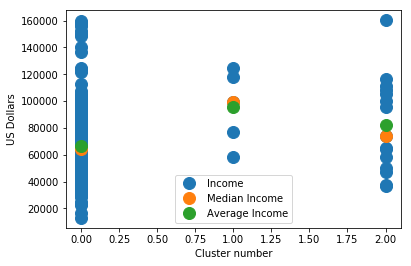

In [108]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(LA_reduced["Cluster Labels"], LA_reduced["Income"], marker='o', linestyle='', ms=12)
ax.plot(Median_Median["Cluster Labels"],Median_Median["Income"],marker='o',linestyle='',ms=12, label = "Median Income")
ax.plot(Median_Average["Cluster Labels"],Median_Average["Income"],marker='o',linestyle='',ms=12, label = "Average Income")
ax.legend()
plt.xlabel("Cluster number")
plt.ylabel("US Dollars")
plt.show()

In [86]:
LA_reduced.loc[LA_reduced['Cluster Labels'] == 0, LA_reduced.columns[[1] + [2] + list(range(5, LA_reduced.shape[1]))]].sort_values(by=['Income'])

Neighborhood  Income  \
19   Los Angeles (Downtown Fashion District, Downto...   12864   
49         Los Angeles (Southeast Los Angeles), Vernon   16425   
11   Los Angeles (Downtown Central, Downtown Fashio...   22808   
6    Los Angeles (Southeast Los Angeles, Univerity ...   23070   
166                            Glendale (Verdugo City)   24609   
15   Los Angeles (Downtown Bunker Hill, City West, ...   28638   
34                     Los Angeles (South Los Angeles)   31045   
48                              Los Angeles (Westlake)   31337   
30                         Los Angeles (Boyle Heights)   31683   
41             Athens, Los Angeles (South Los Angeles)   32278   
4    Los Angeles (Hancock Park, Koreatown, Wilshire...   32461   
13   Los Angeles (Dowtown Fashion District, South P...   32979   
5    Los Angeles (Byzantine-Latino Quarter, Harvard...   33790   
9                  Los Angeles (Southeast Los Angeles)   33824   
1           Los Angeles (Southeast Los Angeles, Watts)   34000   
151                                         Long Beach   34257   
2    Los Angeles (South Los Angeles, Southeast Los ...   34397   
0     Los Angeles (South Los Angeles), Florence-Graham   35660   
242                                           El Monte   36344   
35                             Los Angeles (Hollywood)   36996   
51                     Los Angeles (South Los Angeles)   37126   
27                        Los Angeles (East Hollywood)   37379   
85                                       Bell, Maywood   37553   
12   Los Angeles (Downtown Historic Core, Arts Dist...   37619   
50   Los Angeles (Southeast Los Angeles, Watts), Wi...   37653   
133                                   Hawaiian Gardens   38500   
178                                 Glendale (Tropico)   38730   
10   Los Angeles (Downtown Civic Center, Chinatown,...   38786   
62                          Bell, Bell Gardens, Cudahy   39498   
52                     Los Angeles (South Los Angeles)   40018   
..                                                 ...     ...   
163                                     South Pasadena   92847   
74                                          El Segundo   92942   
131                                           Lakewood   94110   
183                   Glendale, La Crescenta, Montrose   94322   
264              City of Industry, Diamond Bar, Walnut   95081   
113                                           Whittier   95354   
238                                          Claremont   97002   
126                                           Cerritos   98175   
162                                       Sierra Madre   98547   
155                                            Arcadia   99360   
232         Los Angeles (North Hollywood, Studio City)   99745   
211                       Los Angeles (Woodland Hills)  100323   
89                             Redondo Beach, Torrance  101532   
149                                         Long Beach  102563   
65                                       Beverly Hills  103032   
94      Los Angeles (Marina Peninsula), Marina del Rey  103948   
181                                           Glendale  105000   
90                             Redondo Beach, Torrance  107242   
170                                           Pasadena  112765   
46            Los Angeles (Bel Air Estates, Brentwood)  121671   
57                          Los Angeles (Century City)  123889   
79                                       Hermosa Beach  124849   
61                           Los Angeles (Playa Vista)  136250   
102                                       Santa Monica  140179   
84                                     Manhattan Beach  148899   
63                                       Beverly Hills  149732   
173                                         San Marino  152553   
182              Glendale (Glendale Galleria PO Boxes)  155833   
87   Palos Verdes Estates, Rolling Hills, Rolling H...  158497   
224             

In [87]:
LA_reduced.loc[LA_reduced['Cluster Labels'] == 1, LA_reduced.columns[[1] + [2] + list(range(5, LA_reduced.shape[1]))]].sort_values(by=['Income'])


Neighborhood  Income  \
25   Los Angeles (Griffith Park, Hollywood, Los Feliz)   58344   
245                                           Glendora   76825   
246                                           Glendora   99474   
184                              Agoura Hills, Cornell  117615   
88   Palos Verdes Estates, Rancho Palos Verdes, Rol...  124384   

     Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
25              1.0                 Trail              Mountain   
245             1.0                 Trail               Dog Run   
246             1.0                 Trail               Dog Run   
184             1.0                 Trail           Yoga Studio   
88              1.0                 Trail                  Park   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
25         Scenic Lookout       Automotive Shop          Tennis Court   
245                  Park    Athletics & Sports            Playground   
246                  Park    Athletics & Sports            Playground   
184    Dongbei Restaurant             Drugstore           Dry Cleaner   
88   Other Great Outdoors       Nature Preserve           Yoga Studio   

    6th Most Common Venue        7th Most Common Venue  \
25                   Park                     Bus Stop   
245         Grocery Store            Fish & Chips Shop   
246         Grocery Store            Fish & Chips Shop   
184   Dumpling Restaurant  Eastern European Restaurant   
88              Drugstore                  Dry Cleaner   

          8th Most Common Venue        9th Most Common Venue  \
25         Fast Food Restaurant          Empanada Restaurant   
245  Financial or Legal Service                   Donut Shop   
246  Financial or Legal Service                   Donut Shop   
184           Electronics Store          Empanada Restaurant   
88          Dumpling Restaurant  Eastern European Restaurant   

         10th Most Common Venue  
25   Financial or Legal Service  
245                   Drugstore  
246                   Drugstore  
184       Entertainment Service  
88            Electronics Store

In [88]:
LA_reduced.loc[LA_reduced['Cluster Labels'] == 2, LA_reduced.columns[[1] + [2] + list(range(5, LA_reduced.shape[1]))]].sort_values(by=['Income'])

Neighborhood  Income  \
7    Los Angeles (Baldwin Hills, Crenshaw, Leimert ...   36641   
16          Los Angeles (Jefferson Park, Leimert Park)   37341   
29             Los Angeles (El Sereno, Monterey Hills)   47370   
253                                      Monterey Park   49755   
252                                      Monterey Park   58056   
187  Los Angeles (Canoga Park, West Hills), Box Canyon   64367   
250                  City of Industry, Rowland Heights   64983   
202                        Los Angeles (Mission Hills)   74193   
255                                        Diamond Bar   95285   
95                         Los Angeles (Playa del Rey)  100042   
195             Los Angeles (Northridge, Porter Ranch)  105611   
210                                   Westlake Village  108167   
189              Los Angeles (West Hills), Bell Canyon  111043   
209                                   Westlake Village  116114   
159                               La Cañada Flintridge  160288   

     Cluster Labels 1st Most Common Venue            2nd Most Common Venue  \
7               2.0                  Park  Southern / Soul Food Restaurant   
16              2.0                  Park                      Dry Cleaner   
29              2.0                  Park                      Pizza Place   
253             2.0      Sushi Restaurant               Chinese Restaurant   
252             2.0      Sushi Restaurant               Chinese Restaurant   
187             2.0                  Park                      Pizza Place   
250             2.0            Baby Store                              Gym   
202             2.0                  Park       Construction & Landscaping   
255             2.0  Gym / Fitness Center                           Lounge   
95              2.0                 Beach                      Flower Shop   
195             2.0           Golf Course                Convenience Store   
210             2.0           Golf Course                   Sandwich Place   
189             2.0        Scenic Lookout                            Trail   
209             2.0           Golf Course                   Sandwich Place   
159             2.0   American Restaurant                             Park   

    3rd Most Common Venue    4th Most Common Venue 5th Most Common Venue  \
7                  Bakery       Seafood Restaurant  Fast Food Restaurant   
16             Skate Park      Fried Chicken Joint          Intersection   
29     Chinese Restaurant            Grocery Store           Yoga Studio   
253                  Park  Health & Beauty Service           Video Store   
252                  Park  Health & Beauty Service           Video Store   
187            Food Truck                     Café           Yoga Studio   
250           Video Store       Chinese Restaurant                  Park   
202        Sandwich Place               Food Truck           Yoga Studio   
255    Athletics & Sports                     Park    Dongbei Restaurant   
95                   Park           Scenic Lookout             Surf Spot   
195          Home Service       Chinese Restaurant               Exhibit   
210                Lawyer            Auto Workshop                  Park   
189        Baseball Field                     Park           Event Space   
209                Lawyer            Auto Workshop                  Park   
159          Home Service           Scenic Lookout    Photography Studio   

    6th Most Common Venue 7th Most Common Venue    8th Most Common Venue  \
7                   Trail                Lawyer  New American Restaurant   
16          Grocery Store    Mexican Restaurant             Burger Joint   
29             Donut Shop             Drugstore              Dry Cleaner   
253    Dim Sum Restaurant         Burrito Place           Discount Store   
252    Dim Sum Restaurant         Burrito Place           Discount Store   
187             Drugstore           Dry Cleaner      Dumpling R

In [97]:
LA_gentrify = LA_reduced[LA_reduced["Cluster Labels"] ==2] 
LA_gentrify = LA_gentrify[LA_gentrify["Income"] <= LA_gentrify["Income"].median()].sort_values(by=['Income'])
LA_gentrify

ZIP                                       Neighborhood  Income  \
7    90008  Los Angeles (Baldwin Hills, Crenshaw, Leimert ...   36641   
16   90018         Los Angeles (Jefferson Park, Leimert Park)   37341   
29   90032            Los Angeles (El Sereno, Monterey Hills)   47370   
253  91755                                      Monterey Park   49755   
252  91754                                      Monterey Park   58056   
187  91304  Los Angeles (Canoga Park, West Hills), Box Canyon   64367   
250  91748                  City of Industry, Rowland Heights   64983   
202  91345                        Los Angeles (Mission Hills)   74193   

      Latitude   Longitude  Cluster Labels 1st Most Common Venue  \
7    34.009552 -118.346724             2.0                  Park   
16   34.028887 -118.317183             2.0                  Park   
29   34.078195 -118.185497             2.0                  Park   
253  34.050965 -118.114394             2.0      Sushi Restaurant   
252  34.052922 -118.143465             2.0      Sushi Restaurant   
187  34.224196 -118.632394             2.0                  Park   
250  33.974883 -117.900676             2.0            Baby Store   
202  34.265878 -118.457241             2.0                  Park   

               2nd Most Common Venue 3rd Most Common Venue  \
7    Southern / Soul Food Restaurant                Bakery   
16                       Dry Cleaner            Skate Park   
29                       Pizza Place    Chinese Restaurant   
253               Chinese Restaurant                  Park   
252               Chinese Restaurant                  Park   
187                      Pizza Place            Food Truck   
250                              Gym           Video Store   
202       Construction & Landscaping        Sandwich Place   

       4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
7         Seafood Restaurant  Fast Food Restaurant                 Trail   
16       Fried Chicken Joint          Intersection         Grocery Store   
29             Grocery Store           Yoga Studio            Donut Shop   
253  Health & Beauty Service           Video Store    Dim Sum Restaurant   
252  Health & Beauty Service           Video Store    Dim Sum Restaurant   
187                     Café           Yoga Studio             Drugstore   
250       Chinese Restaurant                  Park            Taco Place   
202               Food Truck           Yoga Studio             Drugstore   

    7th Most Common Venue    8th Most Common Venue  \
7                  Lawyer  New American Restaurant   
16     Mexican Restaurant             Burger Joint   
29              Drugstore              Dry Cleaner   
253         Burrito Place           Discount Store   
252         Burrito Place           Discount Store   
187           Dry Cleaner      Dumpling Restaurant   
250            Food Truck               Soup Place   
202           Dry Cleaner      Dumpling Restaurant   

           9th Most Common Venue       10th Most Common Venue  
7                    Yoga Studio        Entertainment Service  
16             Convenience Store                  Pizza Place  
29           Dumpling Restaurant  Eastern European Restaurant  
253           Mexican Restaurant         Cantonese Restaurant  
252           Mexican Restaurant         Cantonese Restaurant  
187  Eastern European Restaurant            Electronics Store  
250            Convenience Store  Eastern European Restaurant  
202  Eastern European Restaurant            Electronics Store

In [116]:
LA_gentrify.to_excel(excel_writer='LA_gentrify.xlsx')